In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from numpngw import write_apng
from IPython.display import Image
from pendulum import *
import mujoco
from lqr import *


  0%|          | 0/100 [00:00<?, ?it/s]

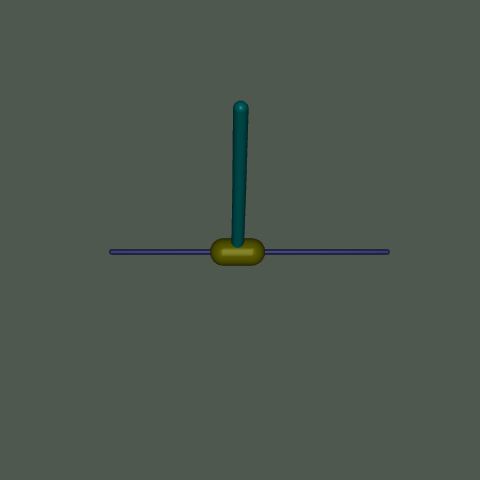

In [3]:
env = gym.make('InvertedDoublePendulum-v4', render_mode='rgb_array')
env.reset()

frames = []  # frames to create animated png
frames.append(env.render())
for i in tqdm(range(100)):
    action = env.action_space.sample()
    s = env.step(action)
    img = env.render()
    frames.append(img)

write_apng("cartpole_example.png", frames, delay=10)
Image(filename="cartpole_example.png")

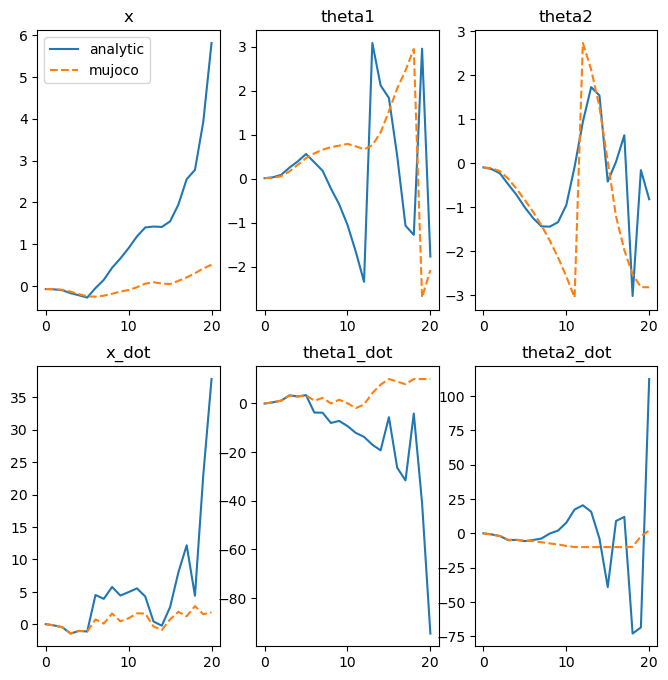

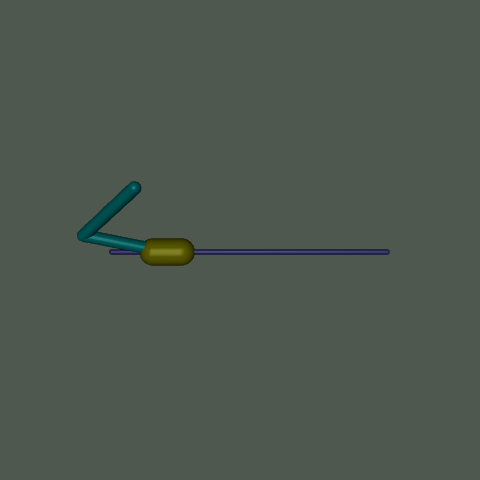

In [4]:
## Let's test to see if your analytic dynamics matches the simulator

frames = []  # frames to create animated png
frames.append(env.render())

# Total time steps
T = 20

# First let's generate a random control sequence
control_sequence = np.random.randn(T, 1)

# We use the simulator to simulate a trajectory
env = gym.make('InvertedDoublePendulum-v4', render_mode='rgb_array')
start_state, _ = env.reset()

states_mujoco = np.zeros((T+1, 8))
states_mujoco[0] = start_state[:8]

for t in range(T):
    #m = np.zeros((3,3))
    #mujoco.mj_fullM(env.model, m, env.data.qM)
    #print("mujoco M ", m)
    #print("mujoco C ", env.data.qfrc_bias)
    #print("mujoco pos ", env.data.qpos)
    #print("mujoco vel ", env.data.qvel)
    #print("mujoco acc ", env.data.qacc)
    #print("mujoco damp", env.data.qfrc_passive)
    full_states_mujoco, _, _, _, _ = env.step(control_sequence[t])
    states_mujoco[t+1] = full_states_mujoco[:8]
    img = env.render()
    frames.append(img)

# Now we will use your analytic dynamics to simulate a trajectory
# Need an extra 1 which is the batch dimension (T x B x 4)
states_analytic = torch.zeros((T+1, 1, 6))
states_analytic[0] = change_of_coords(start_state)
for t in range(T):
    states_analytic[t + 1] = dynamics_analytic(states_analytic[t], torch.from_numpy(control_sequence[t]))

# convert back to numpy for plotting
states_analytic = states_analytic.reshape(T+1, 6)

# convert mujoco states to analytic states
states_mujoco_transformed = T_change_of_coords(states_mujoco)

# Plot and compare - They should be indistinguishable
fig, axes = plt.subplots(2, 3, figsize=(8, 8))

axes[0][0].plot(states_analytic[:, 0], label='analytic')
axes[0][0].plot(states_mujoco_transformed[:, 0], '--', label='mujoco')
axes[0][0].title.set_text('x')

axes[0][1].plot(states_analytic[:, 1])
axes[0][1].plot(states_mujoco_transformed[:, 1], '--')
axes[0][1].title.set_text('theta1')

axes[0][2].plot(states_analytic[:, 2])
axes[0][2].plot(states_mujoco_transformed[:, 2], '--')
axes[0][2].title.set_text('theta2')

axes[1][0].plot(states_analytic[:, 3])
axes[1][0].plot(states_mujoco_transformed[:, 3], '--')
axes[1][0].title.set_text('x_dot')

axes[1][1].plot(states_analytic[:, 4])
axes[1][1].plot(states_mujoco_transformed[:, 4], '--')
axes[1][1].title.set_text('theta1_dot')

axes[1][2].plot(states_analytic[:, 5])
axes[1][2].plot(states_mujoco_transformed[:, 5], '--')
axes[1][2].title.set_text('theta2_dot')

axes[0][0].legend()
plt.show()

write_apng("cartpole_example.png", frames, delay=10)
Image(filename="cartpole_example.png")


In [5]:
# Get properties of the pendulum

import mujoco
env = gym.make('InvertedDoublePendulum-v4', render_mode='rgb_array')
env.reset()
m = env.model.body_mass
l = env.model.geom_size
lcm = env.model.body_ipos
I = env.model.body_inertia
print(m)
print(l)
print(lcm)
print(I)

print(mujoco.mj_name2id(env.model, 1, 'cart'))
print(mujoco.mj_name2id(env.model, 1, 'pole'))
print(mujoco.mj_name2id(env.model, 1, 'pole2'))

print(env.model.dof_damping)
print(env.model.opt.timestep)
print(env.model.opt.gravity)
print(env.model.body_pos)


[ 0.         10.47197551  4.19873858  4.19873858]
[[4.0e+01 4.0e+01 4.0e+01]
 [2.0e-02 1.0e+00 0.0e+00]
 [1.0e-01 1.0e-01 0.0e+00]
 [4.5e-02 3.0e-01 0.0e+00]
 [4.5e-02 3.0e-01 0.0e+00]]
[[0.  0.  0. ]
 [0.  0.  0. ]
 [0.  0.  0.3]
 [0.  0.  0.3]]
[[0.         0.         0.        ]
 [0.1267109  0.1267109  0.04817109]
 [0.15497067 0.15497067 0.00417393]
 [0.15497067 0.15497067 0.00417393]]
1
2
3
[0.05 0.05 0.05]
0.01
[ 1.00e-05  0.00e+00 -9.81e+00]
[[0.  0.  0. ]
 [0.  0.  0. ]
 [0.  0.  0. ]
 [0.  0.  0.6]]


Text(0.5, 0, 'time (s)')

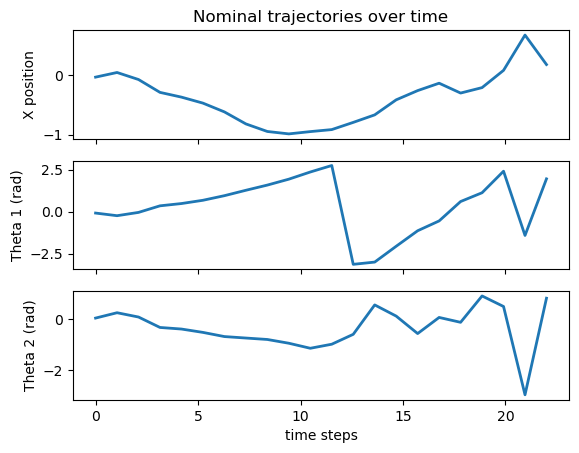

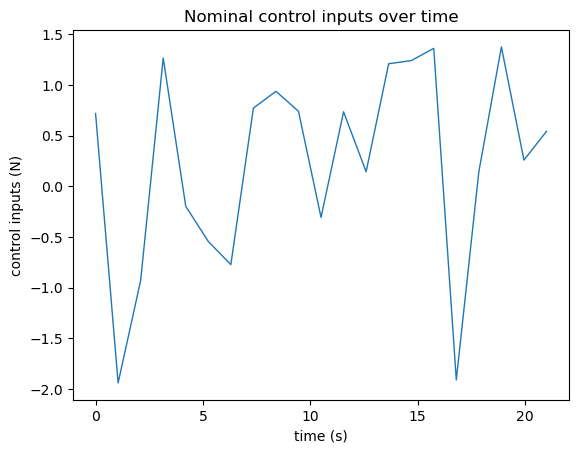

In [8]:
# perform rollouts to obtain the nominal state and control trajectories
env = gym.make('InvertedDoublePendulum-v4', render_mode='rgb_array')
start_state,_ = env.reset()
Tf = 1
dt = 0.05
N = int(Tf/dt + 1)

# start the nominal state trajectory at the initial state from env
init_state = start_state[:8].reshape(8,1)
xs_nom, us_nom = rollout_dynamics(N, init_state)
# print(f'{xs_nom.shape=}')
# print(f'{us_nom.shape=}') 

# plot the nominal trajectory over time
t_vec = np.linspace(0, N+1, N+1)
fig, axs = plt.subplots(3,1,sharex=True)
lin0, = axs[0].plot(t_vec, xs_nom[:,0], lw=2) 
lin1, = axs[1].plot(t_vec, xs_nom[:,1], lw=2)
lin2, = axs[2].plot(t_vec, xs_nom[:,2], lw=2)
axs[0].set_title('Nominal trajectories over time')
axs[0].set_ylabel("X position")
axs[1].set_ylabel("Theta 1 (rad)")
axs[2].set_ylabel("Theta 2 (rad)")
axs[-1].set_xlabel("time steps")  

# plot the nominal control trajectory
plt.figure()
t_vec = np.linspace(0, N, N)
lin0, = plt.plot(t_vec, us_nom[:,0], lw=1)
plt.title('Nominal control inputs over time')
plt.ylabel("control inputs (N)")
plt.xlabel("time (s)")

In [9]:
# verify that we can linearize about a point 
# A_autograd, B_autograd = linearize_pytorch(np.zeros((6)), np.zeros((1)))
A_autograd, B_autograd = linearize_pytorch(torch.zeros((6)), torch.zeros((1)))

print('Autograd linearizations are ')
print(A_autograd.shape)
print(B_autograd.shape)    

Autograd linearizations are 
torch.Size([6, 6])
torch.Size([6, 1])


In [10]:
## define the cost functions

# set the desired state (xstar), should be the goal state
# will will be linearizing about this point
xstar = torch.zeros((6,))
# set the Q and R matrices
# TODO: tune the Q, R amd Qf matrices
Q = torch.eye(6)
R = torch.tensor([1])
Qf = 1000 * torch.eye(6)

# test of the running cost function
# curr_x = xs_nom[0, :].reshape(6,)
# curr_u = us_nom[0, :].reshape(1,)
# running_cost = running_cost_func(curr_x, curr_u, xstar, Q, R)
# print(running_cost)

# # test of the terminal cost fuction
# final_x = xs_nom[-1, :].reshape(6,)
# term_cost = term_cost_func(final_x, xstar, Qf)
# print(term_cost)

# compute the total cost for the nominal trajectory
total_cost = total_cost_func(xs_nom, us_nom, xstar, Q, R, Qf)
print(total_cost)

tensor([3542027.2500])


/Users/marcovaldez/Downloads/DoublePendulum/lqr.py:5: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1678454847243/work/aten/src/ATen/native/TensorShape.cpp:3575.)
  running_cost = 0.5*(curr_x - xstar).T @ Q @ (curr_x - xstar) + 0.5 * curr_u * R * curr_u


In [11]:
# compute the derivatives of the cost functions (ls)
# take the first and second derivative of the quadratic form by hand to avoid having to use symbolic differentiation

# test of lx
Q = torch.eye(6)
curr_x = xs_nom[0, :].reshape(6,1)
xstar = torch.zeros((6,)).reshape(6,1)
lx = ((curr_x-xstar).T @ Q.T).reshape(6,1)
print(lx)

# test of lu
R = torch.eye(1)
curr_u = us_nom[0, :].reshape(1,1)
lu = ((curr_u).T @ R.T).reshape(1,1)
print(lu)

# compute the second derivatives
lxx = Q
luu = R
lxu = 0

tensor([[-0.0341],
        [-0.0838],
        [ 0.0464],
        [ 0.0224],
        [ 0.1213],
        [ 0.0294]])
tensor([[0.7196]])


In [12]:
# compute the first derivatives of q
def compute_qx_qu(lx, A, Vx, lu, B):
    qx = lx + A.T @ Vx
    qu = lu + B.T @ Vx
    return qx, qu

In [13]:
# compute the second derivative of q
def compute_qxx_quu(lxx, A, Vxx, luu, B, lux):
    qxx = lxx + A.T @ Vxx @ A 
    quu = luu + B.T @ Vxx @ B
    qux = lux + B.T @ Vxx @ A
    return qxx, quu, qux

In [23]:
# set up the backward pass function (recursively apply the belman equation)
# proceed backwards in time through the nominal trajectory
def backward_pass(xs_nom, us_nom, xstar, Q, R):

    # get the number of timesteos
    N = xs_nom.shape[0]

    # create a tensor for storing all Vx (jacobian of value function) and Vxx (hessian of the value function) values
    Vxs = torch.zeros((N, 6))
    Vxxs = torch.zeros((N, 6, 6))

    # create a tensor for storing all the gains k and K for the entire trajectory
    ks = torch.ones(N-1, 1, 1) # TODO: initialize to zero?
    Ks = torch.zeros(N-1, 1, 6) # TODO: check the dimensions of these

    # for each value in the nominal trajectory
    for t in reversed(range(1,N,1)): # t goes from N-1 to 1, t-1 goes from N-2 to 0

        # get the current state and control from the nominal trajectory (t-1)
        curr_x = xs_nom[t-1, :].reshape(6,1)
        curr_u = us_nom[t-1, :].reshape(1,1)

        # linearize about the current point in the nominal trajectory (t-1)
        A, B = linearize_pytorch(curr_x, curr_u)  

        # compute the first and second derivative of the lienarized dynamics (lx, lu, etc) (t-1)
        lx = ((curr_x-xstar).T @ Q.T).reshape(6,1)
        lu = ((curr_u).T @ R.T).reshape(1,1)
        lxx = Q
        luu = R
        lux = 0

        # obtain the first and second derivatives of the value function (Vx') for t-1
        Vx = Vxs[t, :].reshape(6,1)
        Vxx = Vxxs[t, :, :].squeeze(0) # (6,6)

        # compute the first derivatives qx and qu (t-1)
        qx, qu = compute_qx_qu(lx, A, Vx, lu, B)

        # compute the second derivatives Qxx, Quu, Qux (t-1)
        qxx, quu, qux = compute_qxx_quu(lxx, A, Vxx, luu, B, lux)
        # print(quu)

        # compute the gains k and K (t-1)
        k = -torch.linalg.inv(quu) @ qu # (1, 1)
        K = -torch.linalg.inv(quu) @ qux # (1, 6)

        # store the new gains in the tensor of all the gains
        ks[t-1, :, :] = k
        Ks[t-1, :, :] = K

        # use the new k and K to compute new values for Vx and Vxx 
        Vx = qx + K.T @ quu @ k + K.T @ qu + qux.T @ k # (6, 1) # TODO: not sure if terms with gains should be pos or neg
        Vxx = qxx + K.T @ quu @ K + K.T @ qux + qux.T @ K # (6,6)

        # update the stored Vxs and Vxxs with the new values for Vx and Vxx
        Vxs[t-1, :] = Vx.reshape(1,6)
        Vxxs[t-1, :] = Vxx

    return ks, Ks

# test the backward pass
ks, Ks = backward_pass(xs_nom, us_nom, xstar, Q, R)
print(ks.shape, Ks.shape)


torch.Size([21, 1, 1]) torch.Size([21, 1, 6])


In [24]:
# set up the forward pass function to obtain the new xs and us

def forward_pass(ks, Ks, N, xs_nom, us_nom):
    # save a tensor of all the new states and control inputs
    us = torch.zeros((N-1, 1))
    xs = torch.zeros((N, 6))

    # set the first stae of the new xs equal to the first state of the nominal x
    xs[0, :] = xs_nom[0, :]

    # iterate through all the timepoints
    for t in range(N-1): # t goes from 0 to N-2
        # print(t)
        # get the nominal u, nominal x, and current x for the given timstep
        curr_nom_u = us_nom[t, :].reshape(1,1)
        curr_nom_x = xs_nom[t, :].reshape(6,1)
        curr_x = xs[t, :].reshape(6,1)

        # get the current gains for the given timestep
        k = ks[t, :].reshape(1,1)
        # print(k)
        K = Ks[t, :].reshape(6,1)
        # print(K)

        # calculate delta x from the current x and the nominal x
        delta_x = curr_x - curr_nom_x 
        # calculate delta u using the gains and delta x
        delta_u = k + torch.dot(K.squeeze(-1), delta_x.squeeze(-1))
        # calculate the new u from delta u
        curr_u = curr_nom_u + delta_u # (1,1)
        # print(delta_u)
        # print(curr_u)
        # obtain the next state from the dynamics function
        next_x = dynamics_analytic(curr_x.reshape(1,6), curr_u) # (1,6)

        # save the current u and the next x to the stored vectors of us and xs
        us[t, :] = curr_u
        xs[t+1, :] = next_x

    return us, xs

N = xs_nom.shape[0]
us, xs = forward_pass(ks, Ks, N, xs_nom, us_nom)
print(us.shape, xs.shape)


torch.Size([21, 1]) torch.Size([22, 6])


Text(0.5, 0, 'time (s)')

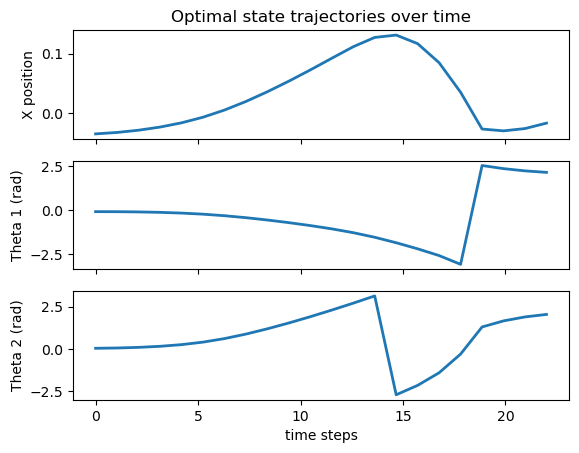

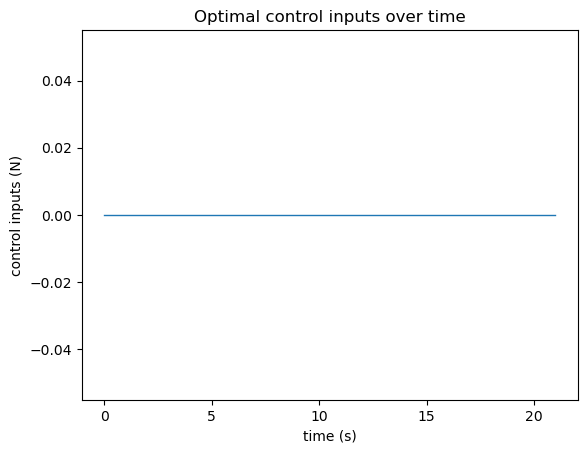

In [25]:
## perform iLQR
# run loop until convergence is reached
num_iterations = 20
N = xs_nom.shape[0]
i = 0
while i < num_iterations:
    # perform the backwards pass
    ks, Ks = backward_pass(xs_nom, us_nom, xstar, Q, R)

    # perform the forward pass
    us, xs = forward_pass(ks, Ks, N, xs_nom, us_nom)

    i += 1

# plot the optimal state trajectory over time
t_vec_x = np.linspace(0, N, N)
fig, axs = plt.subplots(3,1,sharex=True)
lin0, = axs[0].plot(t_vec_x, xs[:,0], lw=2) 
lin1, = axs[1].plot(t_vec_x, xs[:,1], lw=2)
lin2, = axs[2].plot(t_vec_x, xs[:,2], lw=2)
axs[0].set_title('Optimal state trajectories over time')
axs[0].set_ylabel("X position")
axs[1].set_ylabel("Theta 1 (rad)")
axs[2].set_ylabel("Theta 2 (rad)")
axs[-1].set_xlabel("time steps")  

# plot the optimal control trajectory
plt.figure()
t_vec_u = np.linspace(0,N-1,N-1)
lin0, = plt.plot(t_vec, us[:,0], lw=1)
plt.title('Optimal control inputs over time')
plt.ylabel("control inputs (N)")
plt.xlabel("time (s)")


In [26]:
print(us)

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]])
